<a href="https://colab.research.google.com/github/LukasSales/Desafio_back_end_2/blob/feature%2Fanalise-exploratoria/Desafio_back_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Desafio_2

##Bibliotecas Necessárias

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import xgboost as xgb

!pip install --upgrade scikit-learn
!python -m textblob.download_corpora

from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# Configurar visualizações
%matplotlib inline
sns.set(style="whitegrid")

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


##Carregar o Dataset

In [61]:
# Download latest version
path = kagglehub.dataset_download("pypiahmad/goodreads-book-reviews1")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/pypiahmad/goodreads-book-reviews1/versions/1


In [62]:
print("Caminho para os arquivos do dataset:", path)

# Listar todos os arquivos e diretórios
for root, dirs, files in os.walk(path):
    for filename in files:
        print(os.path.join(root, filename))

Caminho para os arquivos do dataset: /root/.cache/kagglehub/datasets/pypiahmad/goodreads-book-reviews1/versions/1
/root/.cache/kagglehub/datasets/pypiahmad/goodreads-book-reviews1/versions/1/goodreads_book_works.json
/root/.cache/kagglehub/datasets/pypiahmad/goodreads-book-reviews1/versions/1/goodreads_interactions.csv
/root/.cache/kagglehub/datasets/pypiahmad/goodreads-book-reviews1/versions/1/goodreads_books.json
/root/.cache/kagglehub/datasets/pypiahmad/goodreads-book-reviews1/versions/1/download.ipynb
/root/.cache/kagglehub/datasets/pypiahmad/goodreads-book-reviews1/versions/1/goodreads_book_genres_initial.json
/root/.cache/kagglehub/datasets/pypiahmad/goodreads-book-reviews1/versions/1/reviews.ipynb
/root/.cache/kagglehub/datasets/pypiahmad/goodreads-book-reviews1/versions/1/goodreads_book_authors.json
/root/.cache/kagglehub/datasets/pypiahmad/goodreads-book-reviews1/versions/1/goodreads_book_series.json
/root/.cache/kagglehub/datasets/pypiahmad/goodreads-book-reviews1/versions/1/

###Carregar o Dataset no DataFrame

In [63]:
n = 100000  # Número de linhas a serem lidas

In [64]:
json_file = os.path.join(path, 'goodreads_reviews_dedup.json')

# Carregar uma amostra do arquivo para evitar sobrecarregar a memória
df = pd.read_json(json_file, lines=True, chunksize=n)
df = next(df)

In [65]:
json_file_books = os.path.join(path, 'goodreads_books.json')

# Carregar o arquivo
df_books = pd.read_json(json_file_books, lines=True, chunksize=n)
df_books = next(df_books)

In [66]:
json_file_authors = os.path.join(path, 'goodreads_book_authors.json')

# Carregar o arquivo
df_authors = pd.read_json(json_file_authors, lines=True, chunksize=n)
df_authors = next(df_authors)

In [67]:
print(df_books.columns)

Index(['isbn', 'text_reviews_count', 'series', 'country_code', 'language_code',
       'popular_shelves', 'asin', 'is_ebook', 'average_rating', 'kindle_asin',
       'similar_books', 'description', 'format', 'link', 'authors',
       'publisher', 'num_pages', 'publication_day', 'isbn13',
       'publication_month', 'edition_information', 'publication_year', 'url',
       'image_url', 'book_id', 'ratings_count', 'work_id', 'title',
       'title_without_series'],
      dtype='object')


In [68]:
print("Estrutura do DataFrame de Autores:")
print(df_authors.head())
print(df_authors.columns)

Estrutura do DataFrame de Autores:
   average_rating  author_id  text_reviews_count              name  \
0            3.98     604031                   7  Ronald J. Fields   
1            4.08     626222               28716     Anita Diamant   
2            3.92      10333                5075    Barbara Hambly   
3            3.68       9212               36262   Jennifer Weiner   
4            3.82     149918                  96     Nigel Pennick   

   ratings_count  
0             49  
1         546796  
2         122118  
3         888522  
4           1740  
Index(['average_rating', 'author_id', 'text_reviews_count', 'name',
       'ratings_count'],
      dtype='object')


In [69]:
df_authors['author_id'] = df_authors['author_id'].astype(str)

In [70]:
#verificar os tipos antes do merge
print(df['book_id'].dtype)
print(df_books['book_id'].dtype)

int64
int64


In [71]:
# Selecionar apenas as colunas necessárias do DataFrame de livros
columns_books = ['book_id', 'title', 'authors', 'popular_shelves']
df_books_selected = df_books[columns_books]

# Realizar o merge interno para evitar NaNs
df = pd.merge(
    df,
    df_books,
    on='book_id',
    how='inner'
)
print(f"Total de linhas após o merge: {df.shape[0]}")

Total de linhas após o merge: 4549


####Explorar o DataFrame

In [72]:
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4549 entries, 0 to 4548
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   user_id               4549 non-null   object
 1   book_id               4549 non-null   int64 
 2   review_id             4549 non-null   object
 3   rating                4549 non-null   int64 
 4   review_text           4549 non-null   object
 5   date_added            4549 non-null   object
 6   date_updated          4549 non-null   object
 7   read_at               4549 non-null   object
 8   started_at            4549 non-null   object
 9   n_votes               4549 non-null   int64 
 10  n_comments            4549 non-null   int64 
 11  isbn                  4549 non-null   object
 12  text_reviews_count    4549 non-null   object
 13  series                4549 non-null   object
 14  country_code          4549 non-null   object
 15  language_code         4549 non-null   

,book_id,rating,n_votes,n_comments
count,4.549000e+03,4549.000000,4549.000000,4549.000000
mean,1.187329e+07,3.699275,0.917344,0.204001
std,1.005823e+07,1.236413,5.324867,1.055693
min,4.200000e+02,0.000000,0.000000,0.000000
25%,9.725280e+05,3.000000,0.000000,0.000000
50%,1.119362e+07,4.000000,0.000000,0.000000
75%,1.877436e+07,5.000000,1.000000,0.000000
max,3.623267e+07,5.000000,280.000000,43.000000


In [73]:
df['average_rating'] = pd.to_numeric(df['average_rating'], errors='coerce')
df['ratings_count'] = pd.to_numeric(df['ratings_count'], errors='coerce')

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4549 entries, 0 to 4548
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               4549 non-null   object 
 1   book_id               4549 non-null   int64  
 2   review_id             4549 non-null   object 
 3   rating                4549 non-null   int64  
 4   review_text           4549 non-null   object 
 5   date_added            4549 non-null   object 
 6   date_updated          4549 non-null   object 
 7   read_at               4549 non-null   object 
 8   started_at            4549 non-null   object 
 9   n_votes               4549 non-null   int64  
 10  n_comments            4549 non-null   int64  
 11  isbn                  4549 non-null   object 
 12  text_reviews_count    4549 non-null   object 
 13  series                4549 non-null   object 
 14  country_code          4549 non-null   object 
 15  language_code        

##Análise Exploratória dos Dados

###Visualização da Distribuição das Avaliações

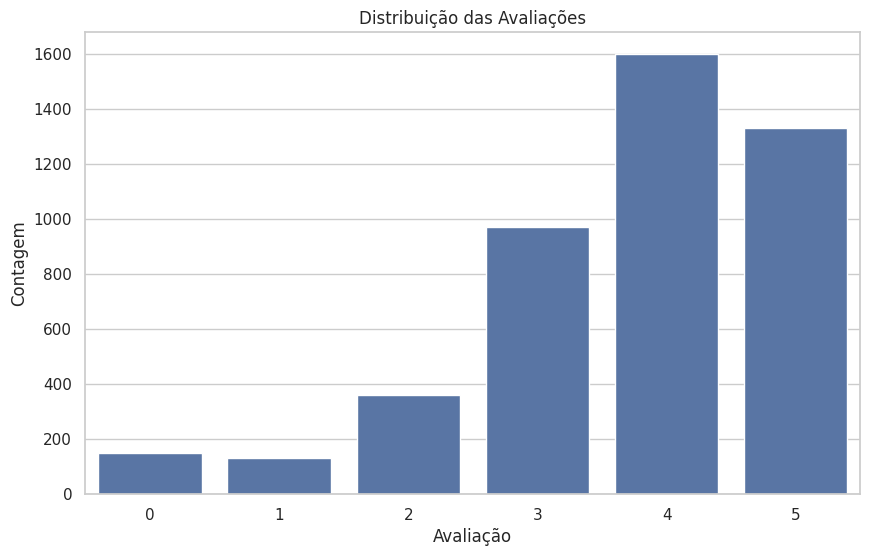

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='rating', data=df)
plt.title('Distribuição das Avaliações')
plt.xlabel('Avaliação')
plt.ylabel('Contagem')
plt.show()

####Livros Mais Avaliados

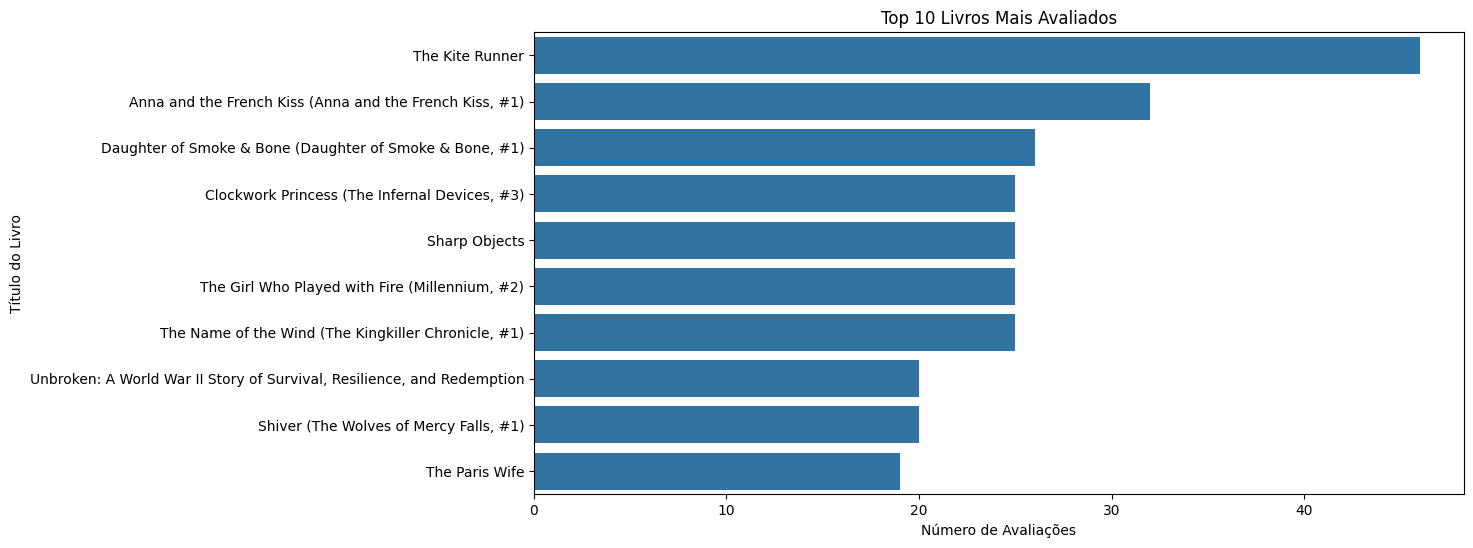

In [ ]:
top_books = df['title'].value_counts().head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=top_books.values, y=top_books.index)
plt.title('Top 10 Livros Mais Avaliados')
plt.xlabel('Número de Avaliações')
plt.ylabel('Título do Livro')
plt.show()

### Autores mais populares


In [ ]:
print(df['authors'].head())

print(df['authors'].apply(type).value_counts())

0     [{'author_id': '28186', 'role': ''}]
1     [{'author_id': '30913', 'role': ''}]
2     [{'author_id': '96150', 'role': ''}]
3    [{'author_id': '103752', 'role': ''}]
4      [{'author_id': '3618', 'role': ''}]
Name: authors, dtype: object
authors
<class 'list'>    4549
Name: count, dtype: int64


###mapeamento

In [ ]:
# Garantir que todos os author_id são strings e sem espaços
df_authors['author_id'] = df_authors['author_id'].astype(str).str.strip()

# Recriar o mapeamento
author_id_to_name = pd.Series(df_authors['name'].values, index=df_authors['author_id']).to_dict()

# Verificar o mapeamento
print("\nExemplos de mapeamento 'author_id' para 'name':")
print(list(author_id_to_name.items())[:5])


Exemplos de mapeamento 'author_id' para 'name':
[('604031', 'Ronald J. Fields'), ('626222', 'Anita Diamant'), ('10333', 'Barbara Hambly'), ('9212', 'Jennifer Weiner'), ('149918', 'Nigel Pennick')]


In [76]:
def parse_authors_with_name(authors, mapping=None):
    try:
        parsed_authors = []

        if isinstance(authors, list):
            for author in authors:
                if isinstance(author, dict) and 'author_id' in author:
                    if author.get('role', '') in ['', 'Writer']:
                        author_id = str(author.get('author_id', '')).strip()
                        # Busca o nome pelo mapeamento
                        name = mapping.get(author_id, 'Desconhecido') if mapping else 'Desconhecido'
                        parsed_authors.append(name)
        return parsed_authors if parsed_authors else ['Desconhecido']
    except Exception as e:
        print(f"Erro ao parsear autores: {e} | authors: {authors}")
        return

In [77]:
if author_id_to_name:
    print("\nAplicando a função de parse de autores com mapeamento atualizado...")
    df['authors_parsed'] = df['authors'].apply(lambda x: parse_authors_with_name(x, author_id_to_name))
    # Extrair o primeiro autor para simplificar a análise
    df['author'] = df['authors_parsed'].apply(lambda x: x[0] if len(x) > 0 else 'Desconhecido')
    print("Função de parse de autores aplicada com sucesso.")
else:
    print("\nMapeamento de 'author_id' para 'name' não está disponível. Usando 'author_id's como identificadores.")
    df['authors_parsed'] = df['authors'].apply(lambda x: parse_authors_with_name(x))
    # Extrair o primeiro autor para simplificar a análise
    df['author'] = df['authors_parsed'].apply(lambda x: x[0] if len(x) > 0 else 'Desconhecido')

# Verificar os resultados após parse_authors
print("\nResultados após parse_authors:")
print(df[['authors', 'authors_parsed', 'author']].head(10))


Aplicando a função de parse de autores com mapeamento atualizado...
Função de parse de autores aplicada com sucesso.

Resultados após parse_authors:
                                             authors  \
0               [{'author_id': '28186', 'role': ''}]   
1               [{'author_id': '30913', 'role': ''}]   
2               [{'author_id': '96150', 'role': ''}]   
3              [{'author_id': '103752', 'role': ''}]   
4                [{'author_id': '3618', 'role': ''}]   
5                [{'author_id': '2462', 'role': ''}]   
6                [{'author_id': '1377', 'role': ''}]   
7                 [{'author_id': '569', 'role': ''}]   
8  [{'author_id': '7214094', 'role': ''}, {'autho...   
9             [{'author_id': '6994731', 'role': ''}]   

                             authors_parsed               author  
0                           [Anthony Doerr]        Anthony Doerr  
1                       [Laura Hillenbrand]    Laura Hillenbrand  
2                          [Dani


Identificando os autores mais populares...

Top 10 Autores Mais Populares:
author
Khaled Hosseini      46
Desconhecido         43
Laini Taylor         34
Stephanie Perkins    34
Maggie Stiefvater    30
Stephen King         28
Cassandra Clare      27
Colleen Hoover       27
Gillian Flynn        25
Stieg Larsson        25
Name: count, dtype: int64


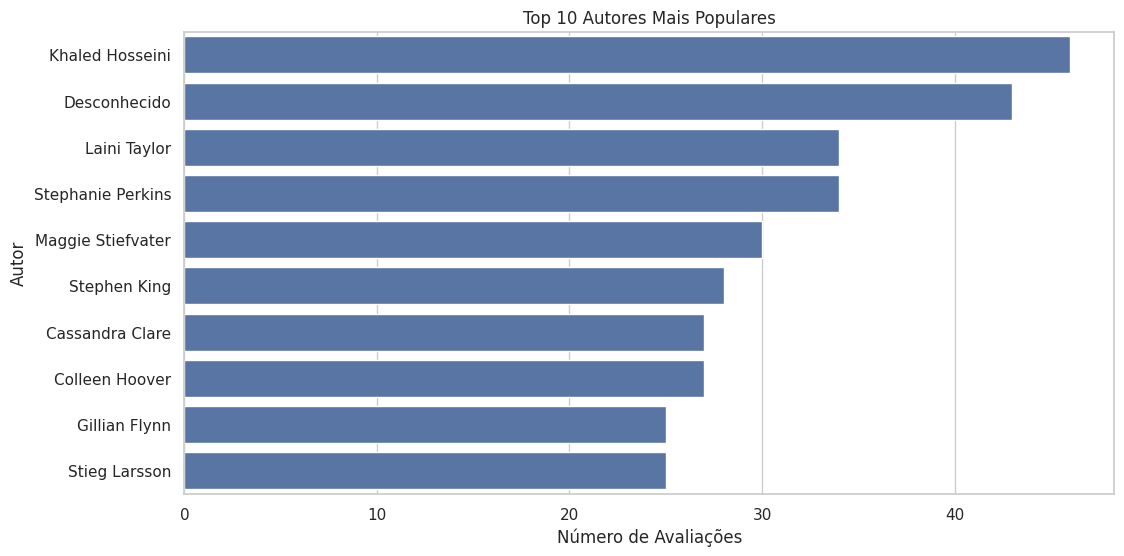

In [79]:
print("\nIdentificando os autores mais populares...")
top_authors = df['author'].value_counts().head(10)
print("\nTop 10 Autores Mais Populares:")
print(top_authors)

# Plotar os Autores Mais Populares
plt.figure(figsize=(12,6))
sns.barplot(x=top_authors.values, y=top_authors.index, orient='h')
plt.title('Top 10 Autores Mais Populares')
plt.xlabel('Número de Avaliações')
plt.ylabel('Autor')
plt.show()

###Gêneros Mais Populares

In [80]:
def parse_shelves(shelves):
    try:
        genres = []
        # Verifica se shelves é uma lista
        if isinstance(shelves, list):
            for shelf in shelves:
                # Verifica se shelf é um dicionário e se contém o nome do gênero
                if isinstance(shelf, dict) and 'name' in shelf:
                    genre = shelf['name']
                    genres.append(genre)
        return genres if genres else []  # Retorna a lista de gêneros ou uma lista vazia se nenhum for encontrado
    except Exception as e:
        print(f"Erro ao parsear shelves: {e} | shelves: {shelves}")
        return []

In [81]:
print("\nParseando gêneros...")
df['genres'] = df['popular_shelves'].apply(parse_shelves)
print("Gêneros parseados com sucesso.")

# Verificar os resultados após parse_shelves
print("\nResultados após parse_shelves:")
print(df[['popular_shelves', 'genres']].head(10))


Parseando gêneros...
Gêneros parseados com sucesso.

Resultados após parse_shelves:
                                     popular_shelves  \
0  [{'count': '526189', 'name': 'to-read'}, {'cou...   
1  [{'count': '25721', 'name': 'to-read'}, {'coun...   
2  [{'count': '7943', 'name': 'to-read'}, {'count...   
3  [{'count': '297', 'name': 'to-read'}, {'count'...   
4  [{'count': '12372', 'name': 'to-read'}, {'coun...   
5  [{'count': '523', 'name': 'to-read'}, {'count'...   
6  [{'count': '61317', 'name': 'to-read'}, {'coun...   
7  [{'count': '13044', 'name': 'favorites'}, {'co...   
8  [{'count': '74', 'name': 'to-read'}, {'count':...   
9  [{'count': '8225', 'name': 'to-read'}, {'count...   

                                              genres  
0  [to-read, currently-reading, historical-fictio...  
1  [to-read, currently-reading, non-fiction, favo...  
2  [to-read, currently-reading, non-fiction, busi...  
3  [to-read, africa, currently-reading, non-ficti...  
4  [to-read, fantasy, y


Analisando os gêneros mais populares...


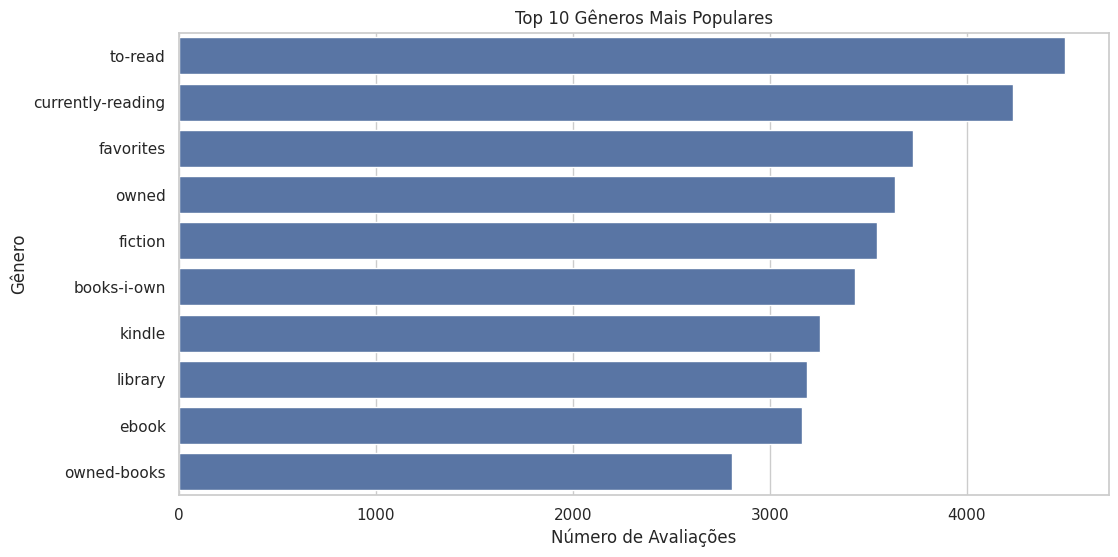

In [82]:
print("\nAnalisando os gêneros mais populares...")
# Explodir a lista de gêneros em múltiplas linhas
genres_exploded = df.explode('genres')

# Contar os gêneros mais populares
top_genres = genres_exploded['genres'].value_counts().head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_genres.values, y=top_genres.index, orient='h')
plt.title('Top 10 Gêneros Mais Populares')
plt.xlabel('Número de Avaliações')
plt.ylabel('Gênero')
plt.show()

####Usuários Mais Ativos


Identificando os usuários mais ativos...


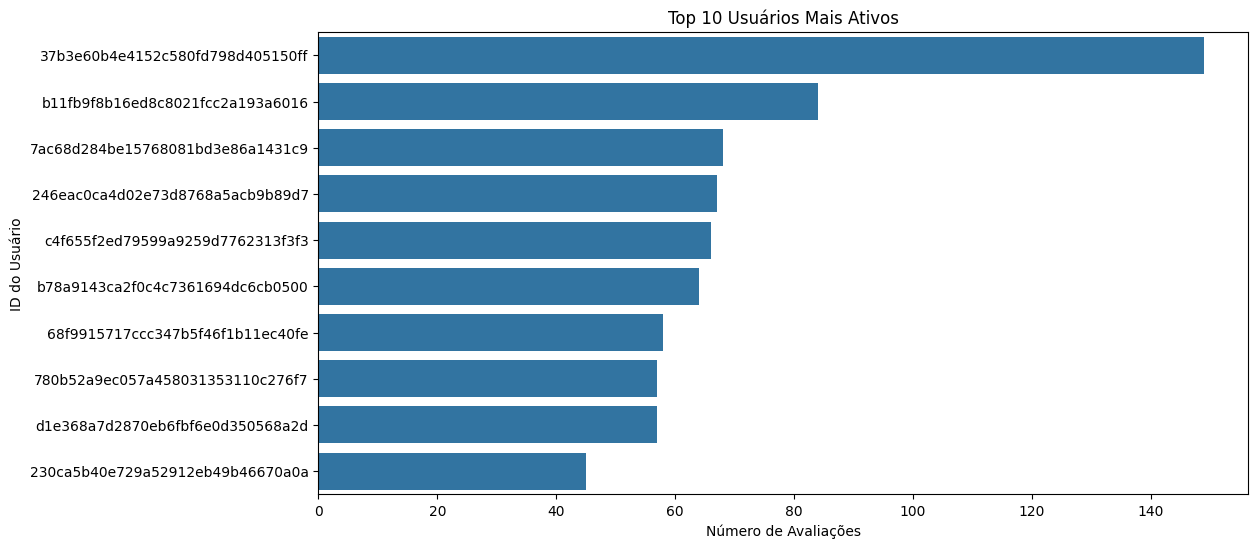

In [ ]:
print("\nIdentificando os usuários mais ativos...")
top_users = df['user_id'].value_counts().head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=top_users.values, y=top_users.index, orient='h')
plt.title('Top 10 Usuários Mais Ativos')
plt.xlabel('Número de Avaliações')
plt.ylabel('ID do Usuário')
plt.show()

###Livros Mais e Menos Bem Avaliados

In [83]:
print("\nIdentificando os livros mais e menos bem avaliados...")
# Calcular a média das avaliações por livro
book_ratings = df.groupby(['book_id', 'title']).agg({'rating': ['mean', 'count']})
book_ratings.columns = ['mean_rating', 'count_rating']
book_ratings = book_ratings.reset_index()

# Definir o número mínimo de avaliações para considerar a média
min_reviews = 3
popular_books = book_ratings[book_ratings['count_rating'] >= min_reviews]

# Verificar se há livros suficientes
if not popular_books.empty:
    # Livros mais bem avaliados
    top_rated_books = popular_books.sort_values(by='mean_rating', ascending=False).head(10)
    print("\nLivros Mais Bem Avaliados:")
    print(top_rated_books[['title', 'mean_rating', 'count_rating']])

    # Livros menos bem avaliados
    worst_rated_books = popular_books.sort_values(by='mean_rating').head(10)
    print("\nLivros Menos Bem Avaliados:")
    print(worst_rated_books[['title', 'mean_rating', 'count_rating']])
else:
    print(f"\nNenhum livro com pelo menos {min_reviews} avaliações foi encontrado.")


Identificando os livros mais e menos bem avaliados...

Livros Mais Bem Avaliados:
                                                  title  mean_rating  \
1809  My Promised Land: The Triumph and Tragedy of I...     5.000000   
1452      Heir of Novron (The Riyria Revelations, #5-6)     5.000000   
1644        Poison Princess (The Arcana Chronicles, #1)     5.000000   
22    The Power of Now: A Guide to Spiritual Enlight...     5.000000   
2309      The Winner's Crime (The Winner's Trilogy, #2)     5.000000   
1898                             The Sea of Tranquility     4.928571   
2935                      March: Book Three (March, #3)     4.800000   
2762                            Hold On (The 'Burg, #6)     4.800000   
1977           Sins & Needles (The Artists Trilogy, #1)     4.750000   
1633       Bitter Blood (The Morganville Vampires, #13)     4.750000   

      count_rating  
1809             3  
1452             3  
1644             4  
22               3  
2309             3 